## Trabajo Integrador Final - Diplomatura en Ciencias Sociales Computacionales
## UnAB
## Guido Edul

El presente trabajo fue desarrollado con la idea de tratar de utilizar conocimientos y herramientas de cada una de las materias de la diplomatura, con excepción de la materia "Sistemas de información Geoespacial para el Análisis Social".

In [19]:
# Importamos las librerías pertinentes; en este caso, librerías de NLP, herramientas estadísticas, y visualización, entre otras.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

In [20]:
# Esta librería fue importada por fines meramente estéticos, 
# para evitar que aparezcan las advertencias a la hora de visualizar con ciertos gráficos. 

import warnings
warnings.filterwarnings("ignore")

In [21]:
# Importamos el dataset y clasificamos los bots de las cuentas reales. El dataset utilizado se encuentra en mi GitHub. 

df = pd.read_csv("Desktop/Twitter_accounts_Dataset.csv")
bots = df[df.bot==1]
reales = df[df.bot==0]

In [22]:
# Revisamos el dataframe.

df.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


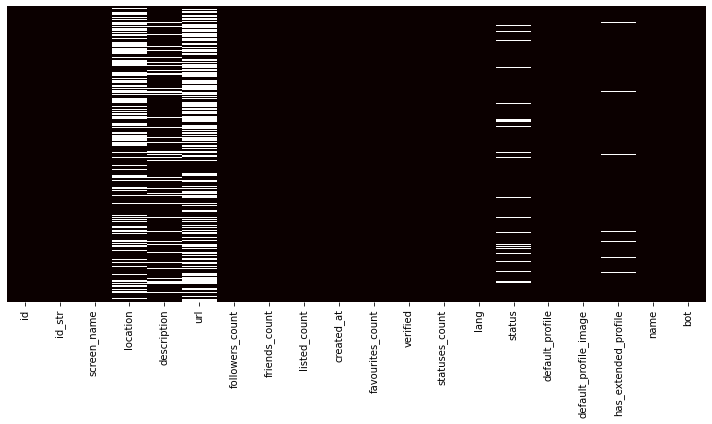

In [23]:
# Realizamos una función para visualizar los valores nulos del Data Frame, usando Seaborn.

def get_heatmap(df):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='hot')
    plt.tight_layout()
    return plt.show()

get_heatmap(df)

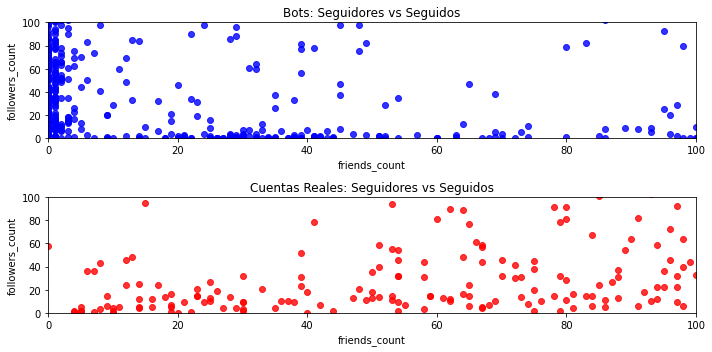

In [24]:
# Visualizamos las variables "seguidores" y "seguidos"; de las cuentas falsas y de las cuentas reales. 
# Podemos apreciar en los gráficos las claras diferencias entre seguidores y seguidos, entre las cuentas bots y las reales.
# Vamos a usar esta información más adelante para nuestro modelo de machine learning;
# ya que hay desbalances en los datos de cada grupo.

bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots: Seguidores vs Seguidos')
sns.regplot(bots.friends_count, bots.followers_count, color='blue', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('Cuentas Reales: Seguidores vs Seguidos')
sns.regplot(reales.friends_count, reales.followers_count, color='red', label='Cuentas Reales')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [25]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

(812, 21)

In [26]:
reales['friends_by_followers'] = reales.friends_count/reales.followers_count
reales[reales.friends_by_followers<1].shape

(952, 21)

(504, 21)


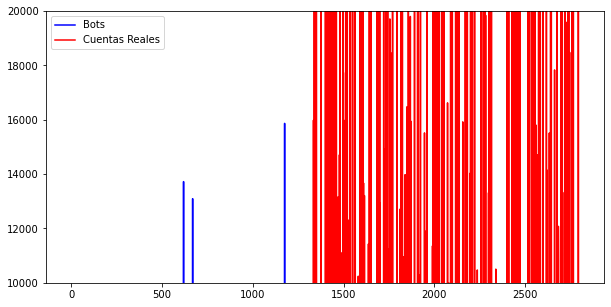

In [27]:
# Visualizamos la cantidad de "listas públicas" de twitter de las cuales son miembro las cuentas bots y las reales.
# Podemos verificar que es otra variable a tener en cuenta. 

plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='blue', label='Bots')
plt.plot(reales.listed_count, color='red', label='Cuentas Reales')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

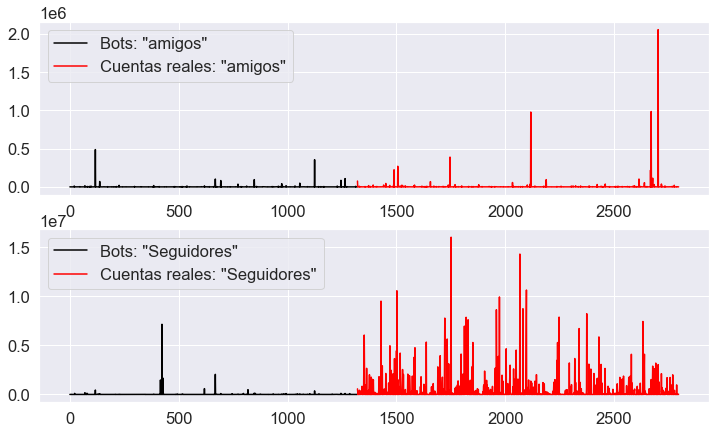

In [40]:
# Visualizamos los "amigos" y los "seguidores"; tanto de los bots como de las cuentas reales.


bots_listed_count_df = bots[bots.listed_count<14000]
reales_listed_count_df = reales[reales.listed_count<14000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape



plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='black', label='Bots: "amigos"')
plt.plot(reales_listed_count_df.friends_count, color='red', label='Cuentas reales: "amigos"')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='black', label='Bots: "Seguidores"')
plt.plot(reales_listed_count_df.followers_count, color='red', label='Cuentas reales: "Seguidores"')
plt.legend(loc='upper left')

In [41]:
nombre_bot = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binario'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binario'] = (bots.location.isnull())
bots['verified_binario'] = (bots.verified==False)
bots.shape

(1321, 24)

In [31]:
nombre_reales = (reales.screen_name.str.contains("bot", case=False)==False)| (reales.description.str.contains("bot", case=False)==False) |(reales.location.isnull()==False)|(reales.verified==True)

reales['screen_name_binario'] = (reales.screen_name.str.contains("bot", case=False)==False)
reales['location_binario'] = (reales.location.isnull()==False)
reales['verified_binario'] = (reales.verified==True)

reales.shape

(1476, 24)

In [32]:
df = pd.concat([bots, reales])
df.shape

(2797, 24)

In [33]:
# Vemos la correlación entre nuestras variables, aplicado a nuestro Data Frame.

df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binario,location_binario,verified_binario
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,0.270435,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,-0.577157,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.427638,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,-0.681034,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.104797,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,-0.419815,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,-0.533971,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,0.197929,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,0.190986,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.044056,-0.843429,-0.266342,0.606771


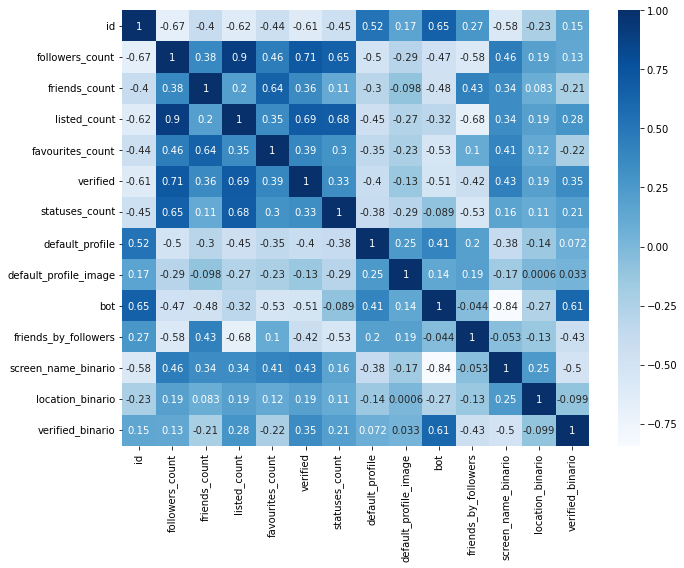

In [34]:
# Visualizamos el Data Frame sobre la correlación entre las variables.

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(method='spearman'), cmap='Blues', annot=True)
plt.tight_layout()
plt.show()

No existe correlación entre id, status_count, default_profile, default_profile_image y la variable objetivo.

Existe una fuerte correlación entre verified, listed_count, friends_count, followers_count y la variable objetivo.

No podemos realizar correlaciones para atributos categóricos. Así que vamos a tomar screen_name, nombre, descripción, estado en la ingeniería de características. Mientras que el uso verificado, listed_count para la extracción de características.

## Desarrollamos un modelo de Árbol de decisión; para estimar si una cuenta es real o es bot.

In [35]:
# Creamos una "bolsa de palabras"; utilizando como criterio las palabras más utilizadas 
# por los bots en inglés (ya que nuestro data set está en inglés); y luego identificarlas en nuestro Data Frame,
# para lo cual creamos "columnas binarias"; para identificar si las palabras identificadas en nuestra bolsa de palabras
# están dentro del Data Frame.

df_ml = pd.read_csv("Desktop/Twitter_accounts_Dataset.csv")

palabras = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
df_ml['screen_name_binario'] = df_ml.screen_name.str.contains(palabras, case=False, na=False)
df_ml['name_binario'] = df_ml.name.str.contains(palabras, case=False, na=False)
df_ml['description_binario'] = df_ml.description.str.contains(palabras, case=False, na=False)
df_ml['status_binario'] = df_ml.status.str.contains(palabras, case=False, na=False)

In [36]:
df_ml['listed_count_binario'] = (df_ml.listed_count>20000)==False
columnas = ['screen_name_binario', 'name_binario', 'description_binario', 'status_binario', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binario', 'bot']

In [37]:
X = df_ml[columnas].iloc[:,:-1]
y = df_ml[columnas].iloc[:,-1]

arbol = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.3, random_state=101)

arbol = arbol.fit(X_entrenamiento, y_entrenamiento)
y_predictivo_entrenamiento = arbol.predict(X_entrenamiento)
y_predictivo_prueba = arbol.predict(X_prueba)

print("Resultado de entrenamiento: %.5f" %accuracy_score(y_entrenamiento, y_predictivo_entrenamiento))
print("Resultado de prueba: %.5f" %accuracy_score(y_prueba, y_predictivo_prueba))

Resultado de entrenamiento: 0.88707
Resultado de prueba: 0.87857


Podemos considerar que el rendimiento del árbol de decisión es aceptable. A continuación graficamos la curva ROC del árbol de decisión, para saber qué tan bien predice los casos; graficando los falsos positivos y los verdaderos positivos:

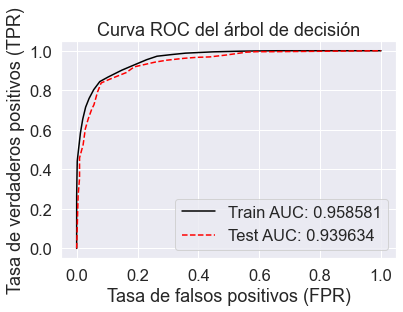

In [42]:
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

resultado_entrenamiento = arbol.predict_proba(X_entrenamiento)
resultado_prueba = arbol.predict_proba(X_prueba)

y_resultado_entrenamiento = []
y_resultado_prueba = []
for i in range(len(resultado_entrenamiento)):
    y_resultado_entrenamiento.append(resultado_entrenamiento[i][1])

for i in range(len(resultado_prueba)):
    y_resultado_prueba.append(resultado_prueba[i][1])
    
arbol_entrenamiento_1, arbol_entrenamiento_2, _ = roc_curve(y_entrenamiento, y_resultado_entrenamiento, pos_label=1)
arbol_prueba_1, arbol_prueba_2, _ = roc_curve(y_prueba, y_resultado_prueba, pos_label=1)

plt.plot(arbol_entrenamiento_1, arbol_entrenamiento_2, color='black', label='Train AUC: %5f' %auc(arbol_entrenamiento_1, arbol_entrenamiento_2))
plt.plot(arbol_prueba_1, arbol_prueba_2, color='red', ls='--', label='Test AUC: %5f' %auc(arbol_prueba_1, arbol_prueba_2))
plt.title("Curva ROC del árbol de decisión")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend(loc='lower right')